In [1]:
import sys
sys.path.append('..')  # Add the parent directory to sys.path

In [2]:
import torch, os
import numpy as np
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from src.utils import train, set_device, beam_search, plot_performance_over_time, compute_accuracy
from src.models import GenerativeRNN, GenerativeLSTM

In [3]:
SEED = 265
torch.manual_seed(SEED)
DEVICE = set_device("cuda")
print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
PATH_GENERATED = "../generated_data/"
mapping = torch.load(PATH_GENERATED + "mapping.pt")
embedding = torch.load(PATH_GENERATED + "embedding_matrix.pt")
vocab = torch.load(PATH_GENERATED + "vocabulary.pt")
words_train = torch.load(PATH_GENERATED + "words_train.pt")
words_val = torch.load(PATH_GENERATED + "words_val.pt")
words_test = torch.load(PATH_GENERATED + "words_test.pt")

In [5]:
# Dataset for text generation
def create_dataset(text, vocab, context_size, map_target=None):
    """
    Create a pytorch dataset of context / target pairs from a text
    """

    n_text = len(text)
    n_vocab = len(vocab)

    if map_target is None:
        map_target = {i: i for i in range(n_vocab)}

    txt = [vocab[w] for w in text]

    contexts = []
    targets = []

    for i in range(context_size, n_text):

        t = txt[i]
        # exclude <unk>(0) and/or punctuation(1) from targets
        if map_target[t] in ["<unk>", ",", ".", "(", ")", "?", "!"]:
            pass
        else:
            # Contex before target
            c = txt[i - context_size : i]
            targets.append(t)
            contexts.append(torch.tensor(c))

    # contexts of shape (N_dataset, contexts_size)
    # targets of shape (N_dataset)
    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    return TensorDataset(contexts, targets)

In [6]:
CONTEXT_SIZE = 30

In [7]:
if os.path.isfile(PATH_GENERATED + "text_generation_data.pt"):
    data_train, data_val, data_test = torch.load(PATH_GENERATED+"text_generation_data.pt")
else:
    data_train = create_dataset(words_train, vocab, CONTEXT_SIZE, mapping)
    data_val = create_dataset(words_val, vocab, CONTEXT_SIZE, mapping)
    data_test = create_dataset(words_test, vocab, CONTEXT_SIZE, mapping)
    torch.save((data_train, data_val, data_test), PATH_GENERATED+"text_generation_data.pt")

In [8]:
print("Size of training data: ", len(data_train))
print("Size of validation data: ", len(data_val))
print("Size of test data: ", len(data_test))

Size of training data:  3225469
Size of validation data:  37937
Size of test data:  89210


# Training

In [9]:
batch_size = 64
n_epochs = 20
loss_fn = nn.CrossEntropyLoss()

print(f"-- Global Parameters --")
print(f"{batch_size=}")
print(f"{n_epochs=}")
print(f"{CONTEXT_SIZE=}") 

model_architectures = [GenerativeRNN, GenerativeLSTM]
# Each model parameter corresponds to the architecture at the same position
model_parameters = [
    [
        {"num_hiddens": 8, "num_layers": 4, "dropout": 0},   
        {"num_hiddens": 16, "num_layers": 8, "dropout": 0.1},   
        {"num_hiddens": 20, "num_layers": 16, "dropout": 0.01},   
    ],
    [
        {"num_hiddens": 8, "num_layers": 4, "dropout": 0},   
        {"num_hiddens": 16, "num_layers": 8, "dropout": 0.1},   
        {"num_hiddens": 20, "num_layers": 16, "dropout": 0.01},   
    ]
]
parameter_search = [
    {"lr":0.008},
    {"lr":0.001},
    {"lr":0.01},
    {"lr":0.0005},
]

-- Global Parameters --
batch_size=64
n_epochs=20
CONTEXT_SIZE=30


In [10]:
train_loader = DataLoader(data_train, batch_size=batch_size)
val_loader = DataLoader(data_val, batch_size=batch_size)

In [11]:

if os.path.isfile(PATH_GENERATED + "text_generation_model.pt"):
    print("Skipping training, loading existing model...")
else:
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    val_perfs = []
    hyper_params = []
    models = []
    architecture_accs = []
    for architecture, m_params in zip(model_architectures, model_parameters):
        model_train_accs = []
        model_val_accs = []
        for params in parameter_search:
            print("\n-- Training with following parameters --:")
            print("\nModel architecture: ", architecture)
            for name, val in params.items():
                print(f"{name}: {val}")
            for m_param in m_params:
                print(m_param)
                
                embedding = embedding.to(DEVICE)
                torch.manual_seed(SEED)
                model = architecture(embedding, **m_param)
                model.to(DEVICE)
                optimizer = Adam(model.parameters(), lr=params["lr"])
    
                train_loss, val_loss, train_acc, val_acc = train(n_epochs, model, optimizer, loss_fn, train_loader, val_loader, DEVICE)
                
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                train_accs.append(train_acc)
                val_accs.append(val_acc)
                val_perfs.append(val_acc[-1])
                model_train_accs.append(train_acc[-1])
                model_val_accs.append(val_acc[-1])
                hyper_params.append({"architecture": architecture, **params, **m_param})
                models.append(model)
                print(f"Train accuracy: {train_acc[-1]*100:.3f}%")
                print(f"Validation accuracy: {val_acc[-1]*100:.3f}%\n")
        architecture_accs.append((np.average(model_train_accs), np.average(model_val_accs)))
            


-- Training with following parameters --:

Model architecture:  <class 'src.models.GenerativeRNN'>
lr: 0.008
{'num_hiddens': 8, 'num_layers': 4, 'dropout': 0}
18:25:16.876381, Epoch: 1, train_loss: 5.089, train_accuracy: 11.904%, val_loss: 5.562, val_accuracy: 11.880%
18:38:46.210329, Epoch: 10, train_loss: 5.042, train_accuracy: 11.645%, val_loss: 5.509, val_accuracy: 11.912%
18:53:47.146001, Epoch: 20, train_loss: 5.061, train_accuracy: 12.142%, val_loss: 5.555, val_accuracy: 12.273%
Train accuracy: 12.142%
Validation accuracy: 12.273%

{'num_hiddens': 16, 'num_layers': 8, 'dropout': 0.1}
18:55:38.286915, Epoch: 1, train_loss: 5.841, train_accuracy: 7.083%, val_loss: 6.369, val_accuracy: 6.648%
19:12:02.536451, Epoch: 10, train_loss: 5.907, train_accuracy: 7.083%, val_loss: 6.543, val_accuracy: 6.648%
19:30:04.905135, Epoch: 20, train_loss: 5.906, train_accuracy: 7.083%, val_loss: 6.545, val_accuracy: 6.648%
Train accuracy: 7.083%
Validation accuracy: 6.648%

{'num_hiddens': 20, 'nu

In [12]:
if os.path.isfile(PATH_GENERATED + "text_generation_model.pt"):
    chosen_model = torch.load(PATH_GENERATED + "text_generation_model.pt")
    chosen_index, train_losses, val_losses, train_accs, val_accs, hyper_params, architecture_accs = torch.load(PATH_GENERATED + "text_generation_plots.pt")
else:
    chosen_index = val_perfs.index(max(val_perfs))
    chosen_model = models[chosen_index]
    torch.save(chosen_model, PATH_GENERATED + "text_generation_model.pt")
    torch.save((chosen_index, train_losses, val_losses, train_accs, val_accs, hyper_params, architecture_accs), PATH_GENERATED + "text_generation_plots.pt")

In [13]:
print("Chosen parameters: ")
print(hyper_params[chosen_index])
print("\nChosen model: ")
print(chosen_model)

Chosen parameters: 
{'architecture': <class 'src.models.GenerativeLSTM'>, 'lr': 0.0005, 'num_hiddens': 16, 'num_layers': 8, 'dropout': 0.1}

Chosen model: 
GenerativeLSTM(
  (embedding): Embedding(3110, 16)
  (lstm): LSTM(16, 16, num_layers=8, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=16, out_features=3110, bias=True)
)


RNN average accuracy: 
Train: 9.692%
Val: 9.564%

LSTM average accuracy: 
Train: 10.153%
Val: 10.067%


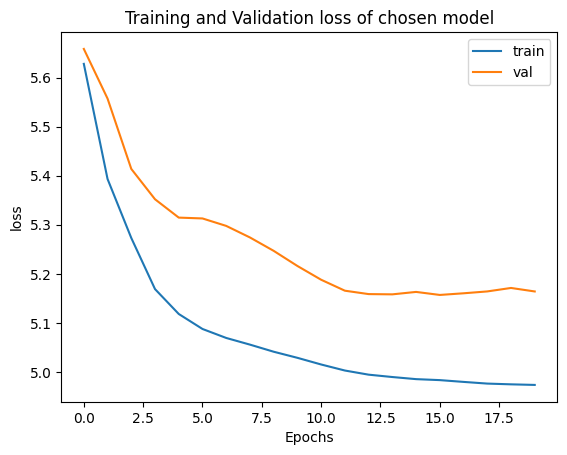

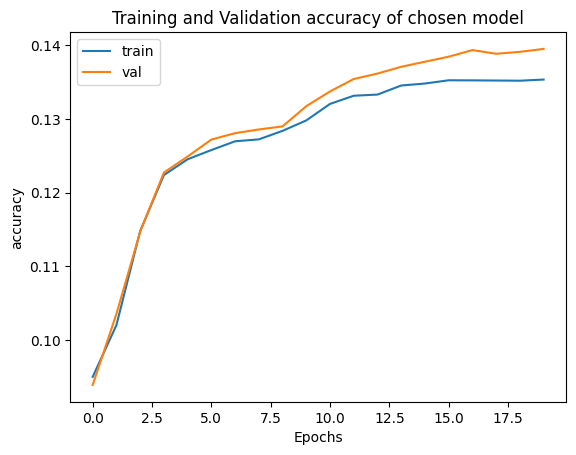

In [14]:
print("RNN average accuracy: ")
print(f"Train: {architecture_accs[0][0]*100:.3f}%")
print(f"Val: {architecture_accs[0][1]*100:.3f}%")
print("\nLSTM average accuracy: ")
print(f"Train: {architecture_accs[1][0]*100:.3f}%")
print(f"Val: {architecture_accs[1][1]*100:.3f}%")

plot_performance_over_time(train_losses[chosen_index], val_losses[chosen_index],
                           "Training and Validation loss of chosen model", "loss",
                            f_name="../images/text_generation_loss.png", save=True)
plot_performance_over_time(train_accs[chosen_index], val_accs[chosen_index],
                           "Training and Validation accuracy of chosen model", "accuracy",
                            f_name="../images/text_generation_accuracy.png", save=True)

In [15]:
test_loader = DataLoader(data_test, batch_size=batch_size)

In [16]:
test_acc = compute_accuracy(chosen_model, test_loader, device=DEVICE)
print(f"Test accuracy: {test_acc*100:.3f}%")

Test accuracy: 15.917%


### Beam Search

In [17]:
# Load a model
model = torch.load("../generated_data/text_generation_model.pt")

In [18]:
# Create test sequences
vocab = torch.load("../generated_data/vocabulary.pt")
mapping = torch.load("../generated_data/mapping.pt")
test_sequences = [
    ["the", "cat", "jumped", "over"],
    ["what", "is", "the", "meaning", "of"],
    ["i", "have", "never"],
    ["the", "woman", "was", "sitting"],
    ["as", "i", "opened", "the"],
    ["to", "be", "or", "not", "to", "be", "?"],
    "a king and queen once upon a time".split(),   # Exists in the training data
    "suddenly the door opened and".split(),
    "in the morning we".split(), 
    "the meaning of life is".split()
]

In [19]:
for i, test_seq in enumerate(test_sequences):
    print_tree = True if i == len(test_sequences)-1 else False
    test_seq_indeces = [vocab[token] for token in test_seq]
    print("\nVocab indices: ", test_seq_indeces)
    print("Prompt: ", test_seq)
    
    gen_seq = beam_search(model, test_seq_indeces, beam_width=3, max_len=10, 
                          print_search_tree=print_tree, gen_sequences=1, length_penalty=0.4)
    gen_seq_to_text = [mapping[token_i] for token_i in gen_seq[0]]
    print("Generated sequence: ", gen_seq_to_text)


Vocab indices:  [2, 1651, 1900, 84]
Prompt:  ['the', 'cat', 'jumped', 'over']
Generated sequence:  ['the', 'cat', 'jumped', 'over', 'the', 'king', 'of', 'the', 'country', 'of', 'the', 'country', 'of', 'the']

Vocab indices:  [61, 16, 2, 1142, 5]
Prompt:  ['what', 'is', 'the', 'meaning', 'of']
Generated sequence:  ['what', 'is', 'the', 'meaning', 'of', 'the']

Vocab indices:  [3109, 30, 138]
Prompt:  ['i', 'have', 'never']
Generated sequence:  ['i', 'have', 'never', 'been']

Vocab indices:  [2, 244, 10, 570]
Prompt:  ['the', 'woman', 'was', 'sitting']
Generated sequence:  ['the', 'woman', 'was', 'sitting', 'in', 'the', 'country', 'of', 'the', 'country', 'of', 'the']

Vocab indices:  [18, 3109, 397, 2]
Prompt:  ['as', 'i', 'opened', 'the']
Generated sequence:  ['as', 'i', 'opened', 'the', 'king', 'of', 'the', 'country', 'of', 'the', 'country', 'of', 'the']

Vocab indices:  [6, 24, 41, 19, 6, 24, 26]
Prompt:  ['to', 'be', 'or', 'not', 'to', 'be', '?']
Generated sequence:  ['to', 'be', 'o